#Тестовое задание для аналитиков-стажеров / Сравни

In [179]:
# Необходимые библиотеки
! pip install pandasql
! pip install sqlalchemy==1.4.46

In [180]:
import pandas as pd
from pandasql import sqldf

**Важно:**

Задания на SQL (1 и 2) выполняются с использованием синтаксиса SQLite внутри Google Colab. [Ссылка](https://www.sqlite.org/lang.html) на документацию.

Но при желании вы можете выполнить эти задания с использованием любого удобного вам диалекта SQL. В данном случае вы самостоятельно выбираете где будете проверять скрипты, будете или нет нагонять туда какие-либо тестовые данные, от вас нам нужен только сам SQL запрос. Обязательно укажите диалект который вы используете.

## Задача 1 (SQL): Исследование данных E-commerce

### Описание задачи



---



**Задача:** Сформировать таблицу сессий пользователей из таблицы событий.

**Сессия** – набор последовательных событий по одному пользователю.

Событие считается первым в сессии если выполняется любое из условий:

1. Это событие - session_start
2. Предыдущие событие - session_end
3. От предыдущего события прошло более 30 минут
4. Наступил новый календарный день
5. Это первое событие пользователя за все время





Необходимо написать SQL-запрос, который создаст таблицу сессий пользователей.

Таблица должна состоять из следующих полей:
1. `SESSION_ID` – уникальный идентификатор сессии
2. `SESSION_START_DTM` – дата и время начала сессии
3. `SESSION_END_DTM` – дата и время конца сессии
4. `USER_ID` – идентификатор пользователя
5. `SESSION_NUMBER` – порядковый номер сессии для данного пользователя
6. `IS_CLIENT` – поле, которое обозначает, является ли пользователь клиентом *(пользователь является клиентом, если за всю историю у него было хотя бы одно событие purchase, не важно в рамках текущей сессии или нет)*



**Дополнительно:** сессия не может состоять только из событий session_start и session_end, такие сессии не должны попасть в результирующую таблицу и не учитываются при формировании поля SESSION_NUMBER.



---



**Схема данных таблицы EVENTS**

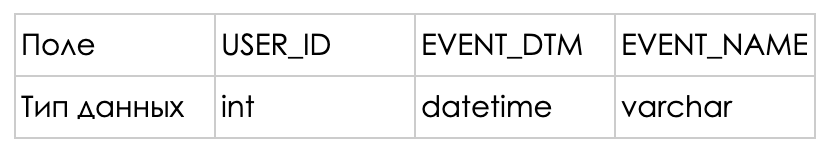

### Решение

В виде ответа на задачу необходимо прикрепить файл `result_task_1.txt` с итоговым SQL запросом в GoogleForms.

In [181]:
# Загружаем данные
# (регистр названия DataFrame важен в SQL запросе)

events = pd.read_csv('events.csv')
events.head()

,USER_ID,EVENT_DTM,EVENT_NAME
0,921021,2023-12-01 00:13:07.000000000,event
1,921021,2023-12-01 00:13:08.000000000,event
2,193576,2023-12-01 00:13:33.000000000,event
3,193576,2023-12-01 00:13:34.000000000,event
4,921021,2023-12-01 00:17:07.000000000,event


In [182]:
with open('result_task_1.txt', 'r') as file:
    # Читаем содержимое файла
    query = file.read()

# Сохраняем результат SQL запроса в pandas DataFrame
result_task_1 = sqldf(query, globals())
result_task_1.head()

,SESSION_ID,SESSION_START_DTM,SESSION_END_DTM,USER_ID,SESSION_NUMBER,IS_CLIENT
0,1,2023-12-01 00:13:07.000000000,2023-12-01 00:21:26.000000000,921021,1,1
1,2,2023-12-01 00:13:33.000000000,2023-12-01 00:31:08.000000000,193576,1,1
2,3,2023-12-01 00:31:09.000000000,2023-12-01 00:32:13.000000000,193576,2,1
3,4,2023-12-01 00:32:21.000000000,2023-12-01 00:33:22.000000000,193576,3,1
4,5,2023-12-01 00:33:24.000000000,2023-12-01 00:59:41.000000000,193576,4,1


## Задача 2 (SQL): Исследование данных Retail

### Описание задачи

Представь, что ты работаешь в retail компании, тебе предоставили доступ к данным компании с информацией о продажах товаров, пользователях компании, ассортименте продуктов, а также о магазинах сети. Общая схема данных выглядит следующим образом:

#### Схема базы данных

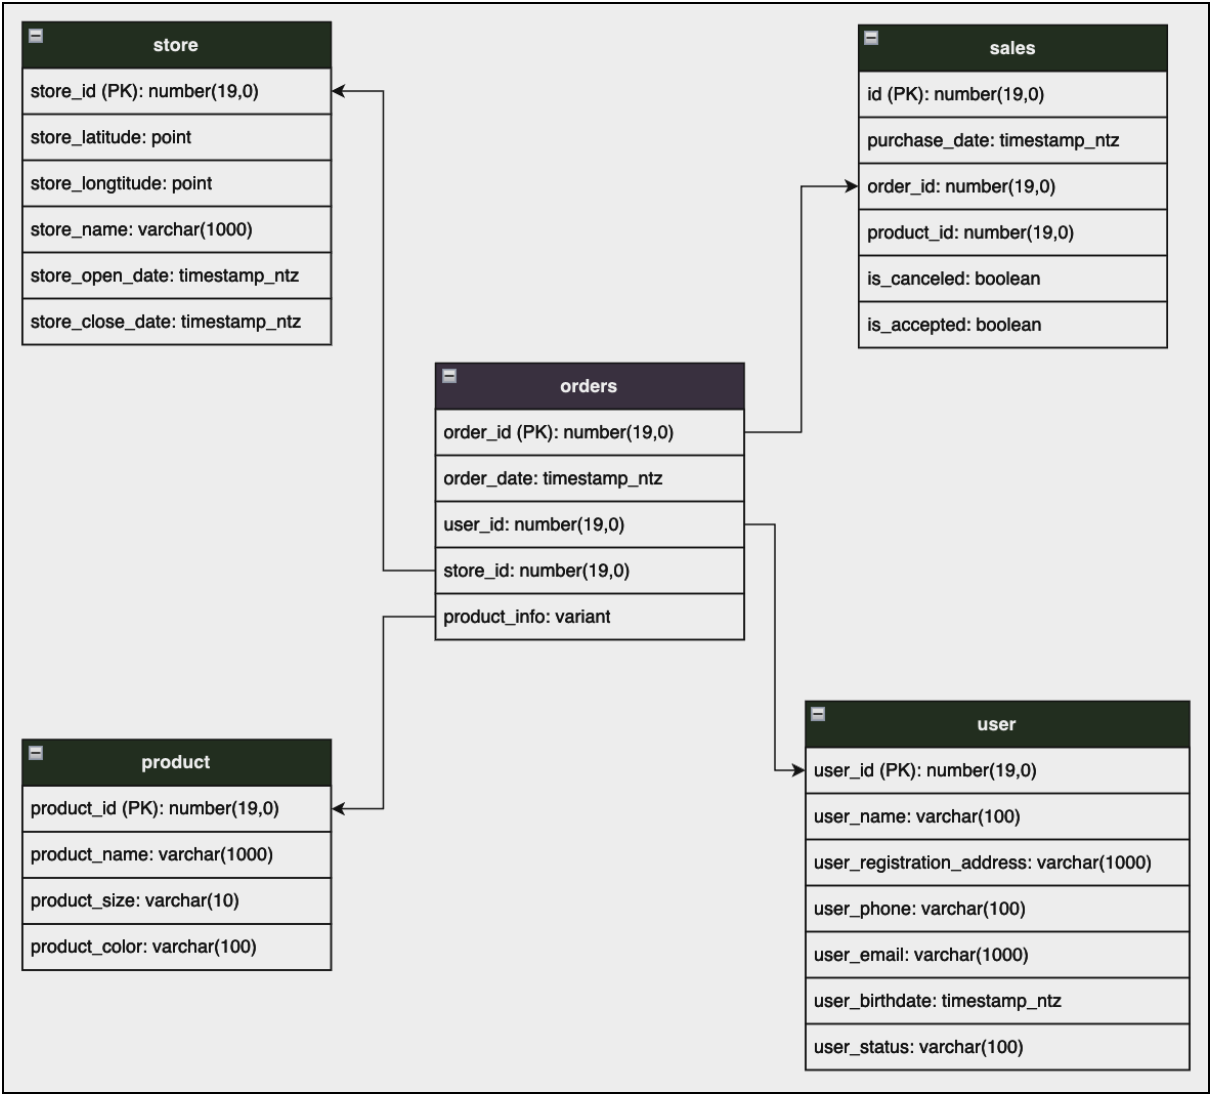

#### Описание базы данных


---



1) **orders** - таблица с информацией о созданных заказах:

* `orders.order_id`: идентификатор заказа (уникальный ключ таблицы)
* `orders.order_date`: дата создания заказа
* `orders.user_id`: идентификатор пользователя, создавшего заказ
* `orders.store_id`: идентификатор магазина, в котором был создан заказ
* `orders.product_info`: массив, содержащий json-объекты с информацией о товарах в заказе, вида:
  * `product_id` - идентификатор товара в заказе
  * `product_price` - цена товара
  * `product_commission` - комиссия за товар, учитываемая как прибыль за данный товар, получаемая компанией
  * `commission_is_percent` - флаг того, что комиссия является процентом от стоимости товара (True), либо фиксированным значением (False)
  * `count` - кол-во единиц данного продукта в заказе

**Вид массива:**

[

{"product_id":1, "product_price":1500, "product commission":70, "commission_is_percent":True, "count":2},
{"product_id":2, "product_price":2000, "product commission":1000, "commission_is_percent":False, "count":1},...

]



---



2) **sales** - таблица с информацией о продажах (совершенных платежах).
Возможные следующие случаи:
1. Если поле is_accepted=True и is_canceled=False, то произошел платеж по товару в заказе.
2. Если поле is_accepted=False и is_canceled=False, то произошло создание платежа по товару, но его еще не оплатили и не отменили.
3. Если поле is_accepted=True и is_canceled=True, то произошел возврат товара по заказу, а товар ранее был оплачен. Клиенту вернется сумма платежа.
4. Если поле is_accepted=False и is_canceled=True, то произошла отмена товара, который ранее не оплачивали.
(если статус платежа по товару меняется, то не создается новая запись в БД, а меняются поля (is_accepted, is_canceled ) в текущей записи).

**Состав таблицы:**

* `sales.id`: идентификатор продажи (уникальный ключ таблицы)
* `sales.purchase_date`: дата продажи
* `sales.order_id`: идентификатор заказа из таблицы orders, на который приходится продажа (на один заказ может быть несколько товаров, и соответственно, несколько продаж)
* `sales.product_id`: идентификатор товара в заказе
* `sales.is_accepted`: флаг подтверждения платежа
* `sales.is_canceled`: флаг подтверждения отмены платежа


---

3) **user** - таблица с информацией о клиентах:

* `user.user_id`: идентификатор пользователя (уникальный ключ таблицы)
* `user.user_name`: ФИО клиента
* `user.user_registration_address`: адрес регистрации клиента (страна/город/адрес)
* `user.user_phone`: телефон клиента
* `user.user_email`: почта клиента
* `user.user_status`: статус клиента


---


4) **store** - таблица с информацией о магазинах:

* `store.store_id`: идентификатор магазина (уникальный ключ таблицы)
* `store.store_latitude`: долгота магазина (географическая координата)
* `store.store_longtitude`: широта магазина (географическая координата)
* `store.store_name`: название магазина
* `store.store_open_date`: дата открытия магазина
* `store.store_close_date`: дата закрытия магазина



---

5) **product** - таблица с информацией о товарах:

* `product.product_id:`: идентификатор товара (уникальный ключ таблицы)
* `product.product_name`: название товара
* `product.product_size`: размер товара
* `product.product_color`: цвет товара


---



#### Постановка задачи

Необходимо создать таблицу агрегированную по пользователям и  выкупленными заказами (в заказах учитывать только выкупленные товары по которым не было возврата).



* `USER_ID` - идентификатор пользователя
* `ORDER_ID` - идентификатор заказа
* `ORDER_DATE` - дата создания заказа
* `ORDER_SUM` - сумма заказа
* `ORDER_REVENUE` - выручка с заказа
* `ORDER_QUANTITY` - суммарное кол-во товаров в заказе
* `ORDER_UNIQUE_PRODUCTS` - кол-во уникальных товаров в заказе (по product_id)


### Решение

В виде ответа на задачу необходимо прикрепить файл result_task_2.txt с итоговым SQL запросом в GoogleForms.

In [183]:
# Загружаем данные
# (регистр названия DataFrame важен в SQL запросе)

orders = pd.read_csv('orders.csv')
sales = pd.read_csv('sales.csv')
user = pd.read_csv('user.csv')
store = pd.read_csv('store.csv')
product = pd.read_csv('product.csv')

orders.tail()

,order_id,order_date,user_id,store_id,product_info
1009995,1009996,2023-11-30,9966,15,"[{'product_id': 138, 'product_price': 9948.590..."
1009996,1009997,2023-11-30,9978,15,"[{'product_id': 1389, 'product_price': 8984.21..."
1009997,1009998,2023-11-30,9979,15,"[{'product_id': 2341, 'product_price': 18336.8..."
1009998,1009999,2023-11-30,9984,15,"[{'product_id': 710, 'product_price': 9029.154..."
1009999,1010000,2023-11-30,9995,15,"[{'product_id': 3052, 'product_price': 24296.5..."


In [185]:
with open('result_task_2.txt', 'r') as file:
    # Читаем содержимое файла
    query = file.read()

# Сохраняем результат SQL запроса в pandas DataFrame
result_task_2 = sqldf(query, globals())
result_task_2.head()

,USER_ID,ORDER_ID,ORDER_DATE,ORDER_SUM,ORDER_REVENUE,ORDER_QUANTITY,ORDER_UNIQUE_PRODUCTS
0,1,6116,2022-03-11,11060.841781,3500,1,1
1,1,22551,2022-06-01,16349.124324,5000,1,1
2,1,42149,2022-08-04,9200.386361,2500,1,1
3,1,43677,2022-08-09,7131.358040,2500,1,1
4,1,46116,2022-08-17,19593.205092,7000,1,1


## Задача 3 (Python/R): Подготовка к встрече с новым владельцем сети магазинов

### Описание задачи

3.1 Завтра состоится встреча с новым владельцами бизнеса. Тебе предстоит подготовить информацию для встречи, где были бы собраны ключевые метрики, графики и сегменты на твой взгляд.

Ты можешь использовать любые данные из задачи 2, любые библиотеки и методы, которые посчитаете необходимыми. Решение предлагается сделать в свободной форме, все файлы результата и реализации выложить в GoogleDrive, ссылку прикрепить в GoogleForms (не забудь предоставить доступы). Единственное ограничение - код должен быть написан на Python или R.

3.2 У Product Ownerа есть желание понять, сколько единиц каждого товара необходимо поставить в каждый из магазинов в следующем месяце. Целью является совершить одну поставку товара в начале месяца и не довозить его больше, до начала следующего.

Ты можешь использовать любые данные из задачи 2, любые библиотеки и методы, которые посчитаете необходимыми. Решение предлагается сделать в свободной форме, все файлы результата и реализации выложить в GoogleDrive, ссылку прикрепить в GoogleForms (не забудь предоставить доступы). Единственное ограничение - код должен быть написан на Python или R.


## 3.1

In [186]:
import pandas as pd
import matplotlib.pyplot as plt

In [187]:
df = result_task_2.copy()
df.columns = df.columns.str.lower()
df['order_date'] = pd.to_datetime(df['order_date'])
df_sorted = df.sort_values(by=['user_id', 'order_date'])
df_sorted['days_between_orders'] = df_sorted.groupby('user_id')['order_date'].diff().dt.days
df_sorted = df_sorted.dropna(subset=['days_between_orders'])
average_interval = df_sorted.groupby('user_id')['days_between_orders'].mean()
average_interval.mean()

30.206838960671377

In [188]:
orders['store_id'].unique()

array([ 6,  5, 10, 15,  2,  1, 13,  3,  9,  7,  8,  4, 14, 11, 12],
      dtype=int64)

Добавим в датасет колонку с названием магазина

In [189]:
data = result_task_2.copy()
data.columns = data.columns.str.lower()
data = pd.merge(data, orders[['order_id', 'store_id']], on='order_id', how='left')
data = pd.merge(data, store[['store_name', 'store_id']], on='store_id', how='left')
data.drop('store_id', axis=1, inplace=True)
data.head()

,user_id,order_id,order_date,order_sum,order_revenue,order_quantity,order_unique_products,store_name
0,1,6116,2022-03-11,11060.841781,3500,1,1,Rio Leninsky
1,1,22551,2022-06-01,16349.124324,5000,1,1,Rio Leninsky
2,1,42149,2022-08-04,9200.386361,2500,1,1,Kapitoly Belyaevo
3,1,43677,2022-08-09,7131.358040,2500,1,1,Kapitoly Belyaevo
4,1,46116,2022-08-17,19593.205092,7000,1,1,Kapitoly Belyaevo


In [190]:
data['order_sum'].mean()

21048.488968129415

In [191]:
store_metrics = data.groupby('store_name').agg({
    'order_id': 'count',
    'order_quantity': 'sum',
    'order_revenue': 'sum'
}).reset_index()
store_metrics.columns = ['store_name', 'total_orders', 'total_quantity', 'total_revenue']
store_metrics = store_metrics.sort_values(by='total_revenue', ascending=False).reset_index(drop=True)
store_metrics['revenue_per_order'] = store_metrics['total_revenue'] / store_metrics['total_quantity']
store_metrics.head(15)

,store_name,total_orders,total_quantity,total_revenue,revenue_per_order
0,Grinvich,30218,45829,170482000,3719.958978
1,Kapitoly Belyaevo,19465,30376,112553500,3705.343034
2,Rio Leninsky,19606,29302,109427000,3734.454986
3,Aviapark,17823,27935,105391000,3772.722391
4,Koltso,16918,25990,96549000,3714.851866
5,Evropeisky,16905,25245,93784000,3714.953456
6,Evropolis,12283,18881,69630500,3687.860812
7,Galereia,10314,16239,59348000,3654.658538
8,Sedmoe Nebo,9040,13795,50808000,3683.073577
9,Kapitoliy Vernadskogo,7039,10708,38926500,3635.272693


In [192]:
store_metrics['total_revenue'].sum()

977648000

Но куда пропали 2 магазина

In [193]:
data = result_task_2.copy()
data.columns = data.columns.str.lower()
data = pd.merge(data, orders[['order_id', 'store_id']], on='order_id', how='left')
data['store_id'].unique()

array([ 6,  5,  1,  3,  4,  7,  2, 10,  9,  8, 13, 14, 15], dtype=int64)

Магазины с id 11 и 12 не отображаются

In [194]:
orders[orders['store_id'] == 12].shape

(45993, 5)

In [195]:
test = pd.merge(sales, orders, on='order_id', how='left')
test[(test['store_id'] == 12) & (test['is_canceled'] == False) & (test['is_accepted'] == True)]

,id,purchase_date,order_id,product_id,is_canceled,is_accepted,order_date,user_id,store_id,product_info


In [196]:
test[(test['store_id'] == 11) & (test['is_canceled'] == False) & (test['is_accepted'] == True)]

,id,purchase_date,order_id,product_id,is_canceled,is_accepted,order_date,user_id,store_id,product_info


Для магазинов 11 и 12 не было продаж, которые не вернули.

Если поле is_accepted=True и is_canceled=False, то произошел платеж по товару в заказе.
Если поле is_accepted=False и is_canceled=False, то произошло создание платежа по товару, но его еще не оплатили и не отменили.
Если поле is_accepted=True и is_canceled=True, то произошел возврат товара по заказу, а товар ранее был оплачен. Клиенту вернется сумма платежа.
Если поле is_accepted=False и is_canceled=True, то произошла отмена товара, который ранее не оплачивали. (если статус платежа по товару меняется, то не создается новая запись в БД, а меняются поля (is_accepted, is_canceled ) в текущей записи).

In [197]:
test[(test['is_canceled'] == False) & (test['is_accepted'] == True)].shape

(1411786, 10)

In [198]:
test[(test['is_canceled'] == True) & (test['is_accepted'] == True)].shape

(1319838, 10)

In [199]:
test[(test['is_canceled'] == True) & (test['is_accepted'] == False)].shape

(185768, 10)

In [200]:
test[(test['is_canceled'] == False) & (test['is_accepted'] == False)].shape

(455697, 10)

1.   96330 товаров - товар оплачен, затем возврат
2.   52576 товаров - отмена товара, который ранее не оплачивали
3.   5806 товаров - создан платеж, не отменен и не оплачен
4.   0 товаров куплены и оплачены

Возможно в этих магазинах продавались некачественные или дефектные товары. Возможно проблемы с обслуживанием, ассортиментом или ценами. Возможны мошеннические схемы или проблемы с учетом.

Выручка по дням

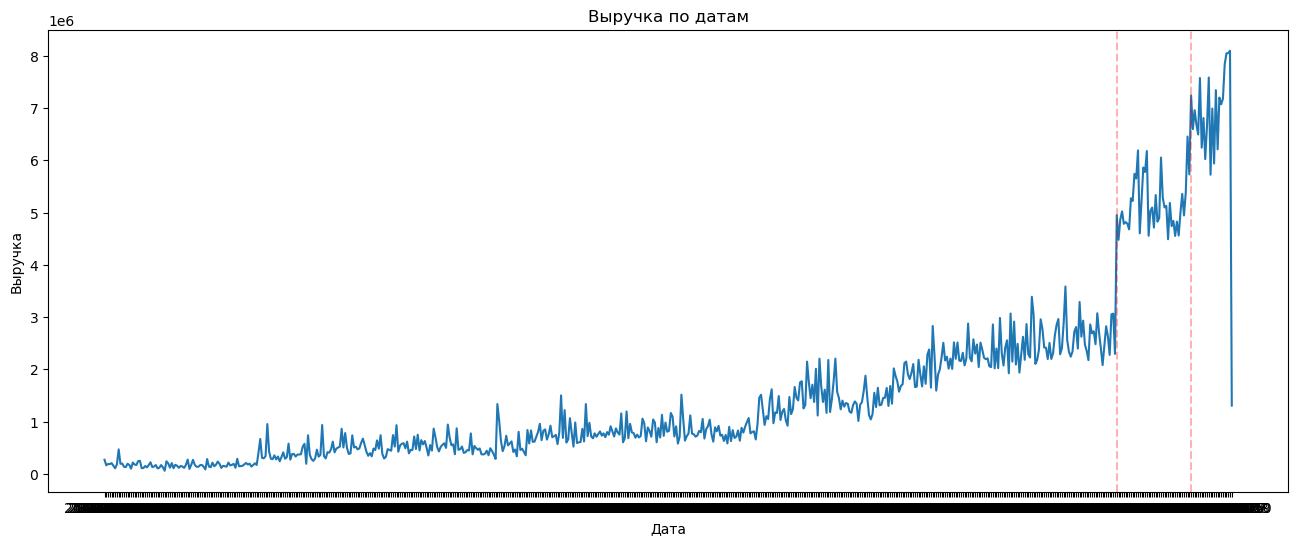

Даты с наибольшими скачками выручки:
2023-08-06
2023-09-17


In [203]:
import matplotlib.pyplot as plt
df = result_task_2.copy()
traffic_data = df.groupby('ORDER_DATE')['ORDER_REVENUE'].sum()

differences = traffic_data.diff().fillna(0)
top2_dates = differences.nlargest(2).index

# Plot the revenue data
plt.figure(figsize=(16, 6))
plt.plot(traffic_data.index, traffic_data.values)
plt.title('Выручка по датам')
plt.xlabel('Дата')
plt.ylabel('Выручка')

for date in top2_dates:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.3)

plt.show()

print("Даты с наибольшими скачками выручки:")
for date in top2_dates:
    print(date)

Общий трафик

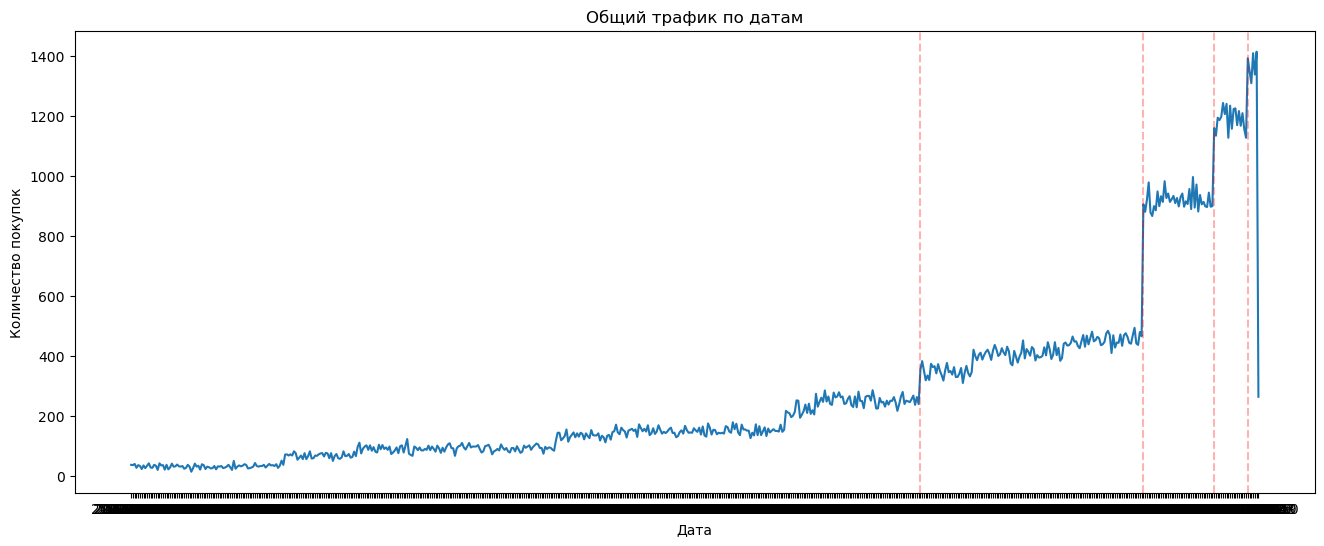

Даты с наибольшими скачками:
2023-08-06
2023-10-04
2023-09-15
2023-04-02


In [206]:
df = result_task_2.copy()
traffic_data = df.groupby('ORDER_DATE')['USER_ID'].count()
differences = traffic_data.diff().fillna(0)
top4_dates = differences.nlargest(4).index

plt.figure(figsize=(16, 6))
plt.plot(traffic_data.index, traffic_data.values)
plt.title('Общий трафик по датам')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')

for date in top4_dates:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.3)
plt.show()

print("Даты с наибольшими скачками:")
for date in top4_dates:
    print(date)

Приток новых посетителей по дням

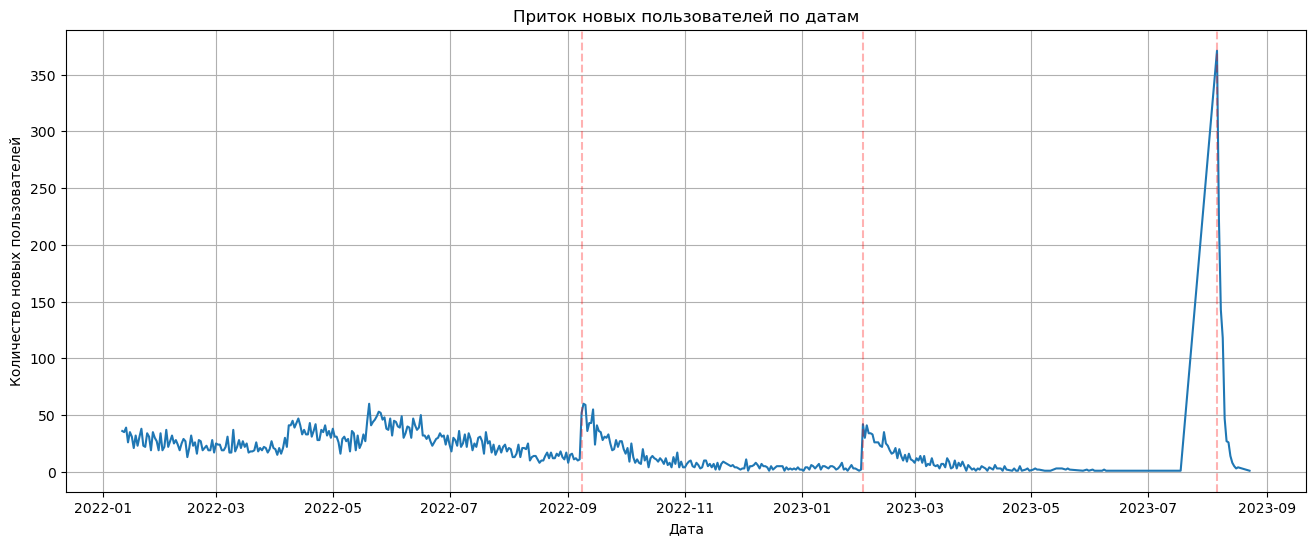

Даты с наибольшими скачками:
2023-08-06
2022-09-08
2023-02-02


In [207]:
df = result_task_2.copy()
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])
first_order_dates = df.groupby('USER_ID')['ORDER_DATE'].min()
new_visitors_traffic = first_order_dates.value_counts().sort_index()

differences = new_visitors_traffic.diff().fillna(0)

top5_dates = differences.nlargest(3).index

plt.figure(figsize=(16, 6))
plt.plot(new_visitors_traffic.index, new_visitors_traffic.values, linestyle='-')
plt.title('Приток новых пользователей по датам')
plt.xlabel('Дата')
plt.ylabel('Количество новых пользователей')
plt.grid(True)
for date in top5_dates:
    plt.axvline(x=date, color='red', linestyle='--', alpha=0.3)

plt.show()


print("Даты с наибольшими скачками:")
for date in top5_dates:
    print(date.date())

In [208]:
df['ORDER_DATE'].min()

Timestamp('2022-01-11 00:00:00')

In [209]:
df = result_task_2.copy()
df.sort_values(by='ORDER_DATE', inplace=True)
df['ORDER_NUMBER'] = df.groupby('USER_ID').cumcount() + 1
funnel = df.groupby('ORDER_NUMBER').size()
funnel.index = [f'{i}-я покупка' for i in funnel.index]

table = pd.DataFrame({
    'Users': funnel.values,
    'Percentage of Previous Stage': [100.0] + [(funnel[i] / funnel[i-1]) * 100 for i in range(1, len(funnel))],
    'Percentage of First Stage': funnel / funnel.iloc[0] * 100
})

table

C:\Users\Home\AppData\Local\Temp\ipykernel_10360\3560793912.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,Users,Percentage of Previous Stage,Percentage of First Stage
1-я покупка,9900,100.000000,100.000000
2-я покупка,9900,100.000000,100.000000
3-я покупка,9899,99.989899,99.989899
4-я покупка,9894,99.949490,99.939394
5-я покупка,9880,99.858500,99.797980
6-я покупка,9848,99.676113,99.474747
7-я покупка,9774,99.248578,98.727273
8-я покупка,9610,98.322079,97.070707
9-я покупка,9382,97.627471,94.767677
10-я покупка,9023,96.173524,91.141414


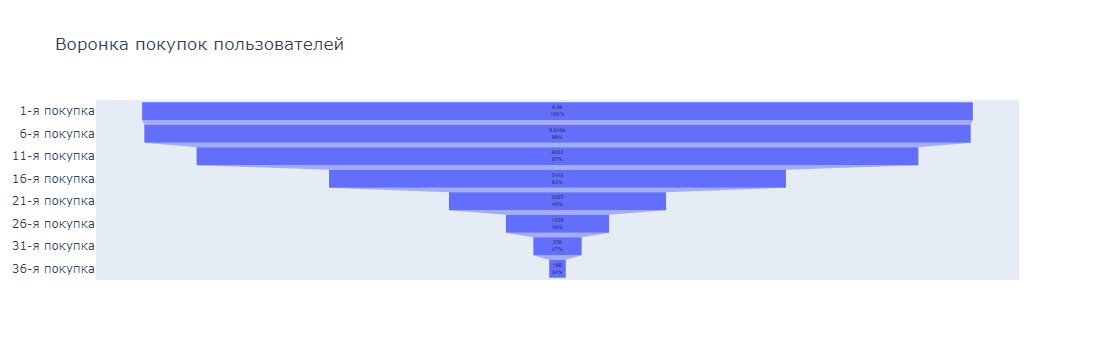

In [210]:
import plotly.graph_objects as go

fig = go.Figure(go.Funnel(
    y = table[:36:5].index,
    x = table['Users'][:36:5],
    textinfo = "value+percent previous",
    textfont = dict(size=10000, family='Arial', color='black') 
))
fig.update_layout(
    title = "Воронка покупок пользователей",
    funnelmode = "stack"
)
fig.show()

ARPU (Average Revenue Per User) Средняя выручка на одного пользователя

In [211]:
total_revenue = result_task_2['ORDER_REVENUE'].sum()  
unique_users = result_task_2['USER_ID'].nunique()  

arpu = total_revenue / unique_users  
arpu

98752.32323232324

LTV

In [213]:
result_task_2['ORDER_DATE'] = pd.to_datetime(result_task_2['ORDER_DATE'])

user_lifetime = result_task_2.groupby('USER_ID')['ORDER_DATE'].agg(['min', 'max']).reset_index()
user_lifetime['lifetime_days'] = (user_lifetime['max'] - user_lifetime['min']).dt.days
user_lifetime['lifetime_months'] = user_lifetime['lifetime_days'] / 30  # Предполагаем 30 дней в месяце

average_lifetime_months = user_lifetime['lifetime_months'].mean()
ltv = arpu * average_lifetime_months
ltv

1353981.13385981

ROI

In [214]:
df = result_task_2.copy()
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])

df['INVESTMENTS'] = df['ORDER_SUM'] - df['ORDER_REVENUE']
roi = ((df['ORDER_SUM'].sum() - df['INVESTMENTS'].sum()) / df['INVESTMENTS'].sum()) * 100
roi

36.930273768449545

In [215]:
df_user['user_birthdate'].describe()

count                         10000
mean     1977-03-05 21:12:05.760000
min             1950-01-04 00:00:00
25%             1963-05-08 06:00:00
50%             1977-03-13 00:00:00
75%             1990-10-28 06:00:00
max             2004-12-27 00:00:00
Name: user_birthdate, dtype: object

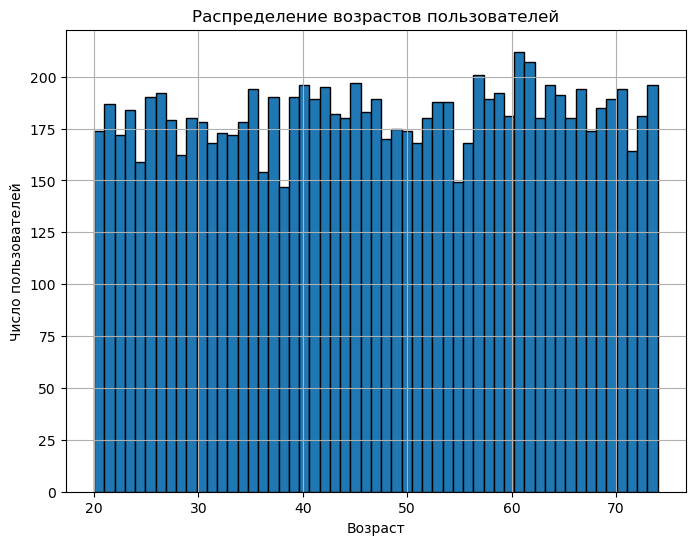

In [216]:
df_user = user.copy()

# Преобразуем столбец с датой рождения в формат datetime
df_user['user_birthdate'] = pd.to_datetime(df_user['user_birthdate'])

# Вычисляем возраст каждого пользователя
current_year = 2024
df_user['age'] = current_year - df_user['user_birthdate'].dt.year

# Построение гистограммы возрастов пользователей
plt.figure(figsize=(8, 6))
plt.hist(df_user['age'], bins=55, edgecolor='black')
plt.title('Распределение возрастов пользователей')
plt.xlabel('Возраст')
plt.ylabel('Число пользователей')
plt.grid(True)

plt.show()

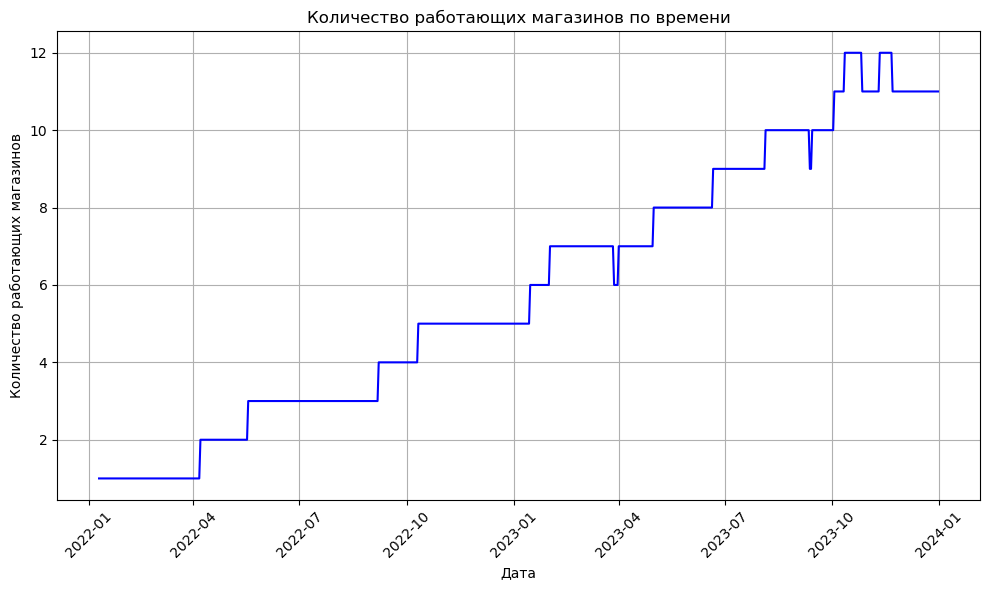

In [217]:
df = pd.DataFrame(store)
df['store_open_date'] = pd.to_datetime(df['store_open_date'])
df['store_close_date'] = pd.to_datetime(df['store_close_date'])
time_series = pd.date_range(start=df['store_open_date'].min(), end=pd.Timestamp('2023-12-31'), freq='D')
working_stores = []

for date in time_series:
    num_open_stores = ((date >= df['store_open_date']) & ((df['store_close_date'].isnull()) | (date <= df['store_close_date']))).sum()
    working_stores.append(num_open_stores)

plt.figure(figsize=(10, 6))
plt.plot(time_series, working_stores, linestyle='-', color='b')
plt.title('Количество работающих магазинов по времени')
plt.xlabel('Дата')
plt.ylabel('Количество работающих магазинов')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3.2

Для определения запаса товаров в магазине предлагается следующий подход. Сначала мы вычисляем среднее количество проданных товаров за те месяцы, в которые был продан хотя бы один экземпляр этого товара. Затем к каждому возможному товару (с учетом его названия, формы и размера, и магазина) добавляем 44 единицы. Почему 44? Потому что это медианное количество проданных товаров для каждого товара, который был продан хотя бы один раз в соответствующем магазине. Таким образом, мы учтем как товары, которые не продавались из-за отсутствия в наличии, так и создадим дополнительный запас. Далее отдельно учитываем магазины Republica и City Mall, данные для которых аномальны. Им проставим дял каждого товара средние значения по остальным магазинам.

### Вычисления

In [218]:
import json
sales_filtered = sales[(sales['is_accepted'] == True) & (sales['is_canceled'] == False)]
merged_data = pd.merge(orders, sales_filtered, on='order_id', how='inner')

def parse_product_info(product_info_str):
    if isinstance(product_info_str, str):
        product_info_str = product_info_str.replace("'", '"')
        product_info_str = product_info_str.replace('True', 'true').replace('False', 'false')
        try:
            return json.loads(product_info_str)
        except json.JSONDecodeError:
            return []
    return []
merged_data['product_info'] = merged_data['product_info'].apply(parse_product_info)

merged_data['order_date'] = pd.to_datetime(merged_data['order_date'])
merged_data['month'] = merged_data['order_date'].dt.month

exploded_data = merged_data.explode('product_info')
exploded_data = exploded_data.reset_index(drop=True)
product_details = pd.json_normalize(exploded_data['product_info'])
product_details = product_details[product_details['product_id'].notna()]

for column in product_details.columns:
  exploded_data[column] = product_details[column]

final_data = pd.merge(exploded_data, product, on='product_id', how='left')
final_data = pd.merge(final_data, store, on='store_id', how='left')
result = final_data.groupby(['store_name', 'product_name', 'product_size', 'product_color', 'month'])['count'].sum().reset_index()
result.tail()

,store_name,product_name,product_size,product_color,month,count
343271,Tsvetnoy,Zenith Zephyr Zip-Up,XXL,Yellow,6,224
343272,Tsvetnoy,Zenith Zephyr Zip-Up,XXL,Yellow,7,13
343273,Tsvetnoy,Zenith Zephyr Zip-Up,XXL,Yellow,8,17
343274,Tsvetnoy,Zenith Zephyr Zip-Up,XXL,Yellow,9,5
343275,Tsvetnoy,Zenith Zephyr Zip-Up,XXL,Yellow,10,5


In [ ]:
result1 = result.groupby(['store_name', 'product_name', 'product_size', 'product_color'])['count'].mean().reset_index()
result1.tail()

In [ ]:
result1.describe()

In [ ]:
all_products_shops = product.merge(store['store_name'], how='cross')
all_products_shops.drop(columns=['product_id'], inplace=True, errors='ignore')
all_products_shops['count'] = result1['count'].median()
all_products_shops.tail()

In [ ]:
answer = pd.concat([all_products_shops, result1]).groupby(['store_name', 'product_name', 'product_size', 'product_color'], as_index=False)['count'].sum()
answer['count'] = answer['count'].astype(int)
answer.tail()

Теперь отдельно учтем магазины Republica и City Mall

In [ ]:
df_copy = answer.copy()
mask = answer['store_name'].isin(['Republica', 'City Mall'])
df_filtered = answer[mask]
df_rest = answer[~mask]
mean_values = df_rest.groupby(['product_name', 'product_size', 'product_color'])['count'].mean().reset_index()
mean_values.rename(columns={'count': 'mean_count'}, inplace=True)
df_merged = pd.merge(df_filtered, mean_values, on=['product_name', 'product_size', 'product_color'], how='left')
df_merged['count'] = df_merged['mean_count']
df_merged.drop(columns=['mean_count'], inplace=True)
df_copy.update(df_merged)

df_copy['count'] = df_copy['count'].astype(int)
answer = df_copy
answer.tail()

In [ ]:
answer.describe()

### Пример использования

In [ ]:
answer.tail()

Пусть мы хотим получить список товаров для магазина Aviapark.

In [ ]:
aviapark_store = answer[answer['store_name'] == 'Aviapark']
aviapark_store = aviapark_store.drop(columns=['store_name'])
aviapark_store.to_csv('aviapark.csv', index=False)
print("Файл сохранен: aviapark.csv")
aviapark_store.tail()